In [23]:
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.0 MB/s eta 0:00:00


In [24]:
# Import required libraries
import numpy as np
import pandas as pd
import re
import random
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from indicnlp import normalize  # Import the normalize module
from nltk.corpus import stopwords
from deep_translator import GoogleTranslator

In [26]:
# Step 1: Synthetic Data Generation with Augmentation
def generate_synthetic_data():
    hindi_samples = [
        "आज का मौसम बहुत अच्छा है।", "क्या तुमने यह किताब पढ़ी है?", "संगीत सुनना मुझे पसंद है।",
        "खेलकूद से शरीर स्वस्थ रहता है।", "नया साल खुशियों से भरा हो।",
        "बीमारियों से बचाव के लिए नियमित व्यायाम जरूरी है।", "शिक्षा से आत्मनिर्भरता बढ़ती है।",
        "मुझे यात्रा करना पसंद है।", "यह जगह बहुत सुंदर है।", "विद्यालय में पढ़ाई बहुत महत्वपूर्ण है।",
        "स्वास्थ्य के लिए संतुलित आहार आवश्यक है।"
    ]
    marathi_samples = [
        "आजचे हवामान खूप छान आहे।", "तुम्ही ही पुस्तक वाचली आहे का?", "संगीत ऐकायला मला आवडते।",
        "खेळामुळे शरीर तंदुरुस्त राहते।", "नवीन वर्ष आनंदाने भरलेले असो।",
        "रोगांपासून संरक्षणासाठी नियमित व्यायाम आवश्यक आहे।", "शिक्षणामुळे आत्मनिर्भरता वाढते।",
        "मी प्रवास करायला आवडतो।", "हे ठिकाण खूप छान आहे।", "शाळेत शिक्षण फार महत्वाचे आहे।",
        "आरोग्यासाठी संतुलित आहार आवश्यक आहे।"
    ]
    punjabi_samples = [
        "ਅੱਜ ਦਾ ਮੌਸਮ ਬਹੁਤ ਵਧੀਆ ਹੈ।", "ਕੀ ਤੁਸੀਂ ਇਹ ਕਿਤਾਬ ਪੜ੍ਹੀ ਹੈ?", "ਮੈਨੂੰ ਸੰਗੀਤ ਸੁਣਨਾ ਪਸੰਦ ਹੈ।",
        "ਖੇਡਾਂ ਨਾਲ ਸਰੀਰ ਤੰਦਰੁਸਤ ਰਹਿੰਦਾ ਹੈ।", "ਨਵਾਂ ਸਾਲ ਖੁਸ਼ੀਆਂ ਨਾਲ ਭਰਿਆ ਹੋਵੇ।",
        "ਬੀਮਾਰੀਆਂ ਤੋਂ ਬਚਣ ਲਈ ਨਿਯਮਤ ਕਸਰਤ ਜਰੂਰੀ ਹੈ।", "ਸਿੱਖਿਆ ਨਾਲ ਆਤਮ-ਨਿਰਭਰਤਾ ਵਧਦੀ ਹੈ।",
        "ਮੈਨੂੰ ਯਾਤਰਾ ਕਰਨੀ ਪਸੰਦ ਹੈ।", "ਇਹ ਥਾਂ ਬਹੁਤ ਸੋਹਣੀ ਹੈ।", "ਸਕੂਲ ਵਿੱਚ ਪੜ੍ਹਾਈ ਬਹੁਤ ਜ਼ਰੂਰੀ ਹੈ।",
        "ਸਿਹਤ ਲਈ ਸੰਤੁਲਿਤ ਖੁਰਾਕ ਜਰੂਰੀ ਹੈ।"
    ]

    def backtranslate(text, lang):
        translated = GoogleTranslator(source=lang, target="en").translate(text)
        return GoogleTranslator(source="en", target=lang).translate(translated)

    hindi_augmented = hindi_samples + [backtranslate(text, "hi") for text in hindi_samples]
    marathi_augmented = marathi_samples + [backtranslate(text, "mr") for text in marathi_samples]
    punjabi_augmented = punjabi_samples + [backtranslate(text, "pa") for text in punjabi_samples]

    hindi_data = [(text, 'Hindi') for text in hindi_augmented]
    marathi_data = [(text, 'Marathi') for text in marathi_augmented]
    punjabi_data = [(text, 'Punjabi') for text in punjabi_augmented]

    data = hindi_data + marathi_data + punjabi_data
    random.shuffle(data)

    return pd.DataFrame(data, columns=['text', 'language'])

df = generate_synthetic_data()
print("Dataset Preview:")
print(df.head(25))


Dataset Preview:
                                                 text language
0                             नया साल खुशी से भरा है।    Hindi
1   बीमारियों को रोकने के लिए नियमित व्यायाम आवश्य...    Hindi
2                           ਅੱਜ ਦਾ ਮੌਸਮ ਬਹੁਤ ਵਧੀਆ ਹੈ.  Punjabi
3                      शाळेत शिक्षण फार महत्वाचे आहे।  Marathi
4                           ਅੱਜ ਦਾ ਮੌਸਮ ਬਹੁਤ ਵਧੀਆ ਹੈ।  Punjabi
5                शिक्षणामुळे स्वत: ची रीलायन्स वाढते.  Marathi
6                स्कूल में अध्ययन बहुत महत्वपूर्ण है।    Hindi
7                               हे ठिकाण खूप छान आहे.  Marathi
8                               यह जगह बहुत सुंदर है।    Hindi
9   रोगांपासून संरक्षण करण्यासाठी नियमित व्यायाम आ...  Marathi
10                          ਮੈਨੂੰ ਯਾਤਰਾ ਕਰਨੀ ਪਸੰਦ ਹੈ।  Punjabi
11                     खेलकूद से शरीर स्वस्थ रहता है।    Hindi
12               शिक्षा आत्म -प्रासंगिक को बढ़ाती है।    Hindi
13                          संगीत सुनना मुझे पसंद है।    Hindi
14                         ਸਕੂਲ ਵਿਚ ਸਿ

In [27]:
# Step 2: Data Preprocessing
normalizer = IndicNormalizerFactory().get_normalizer("hi")  # Hindi normalization, applicable to similar scripts

def preprocess_text(text):
    text = normalizer.normalize(text)  # Normalize Unicode inconsistencies
    text = re.sub(r'[^\u0900-\u097F\u0980-\u09FF\u0A00-\u0A7F]', ' ', text)  # Keep only Indic scripts
    text = re.sub(r'\s+', ' ', text).strip().lower()  # Normalize spaces and lowercase
    return text

df['text'] = df['text'].apply(preprocess_text)

Data Distribution Across Languages:
language
Hindi      22
Punjabi    22
Marathi    22
Name: count, dtype: int64
Most Common Words: [('है।', 19), ('ਹੈ', 12), ('ਹੈ।', 9), ('आहे', 8), ('आवश्यक', 7), ('बहुत', 6), ('से', 5), ('के', 5), ('ਬਹੁਤ', 5), ('आहे।', 5)]
Sentence Length Statistics:
count    66.000000
mean      5.636364
std       1.171933
min       3.000000
25%       5.000000
50%       5.500000
75%       6.000000
max       9.000000
Name: sentence_length, dtype: float64


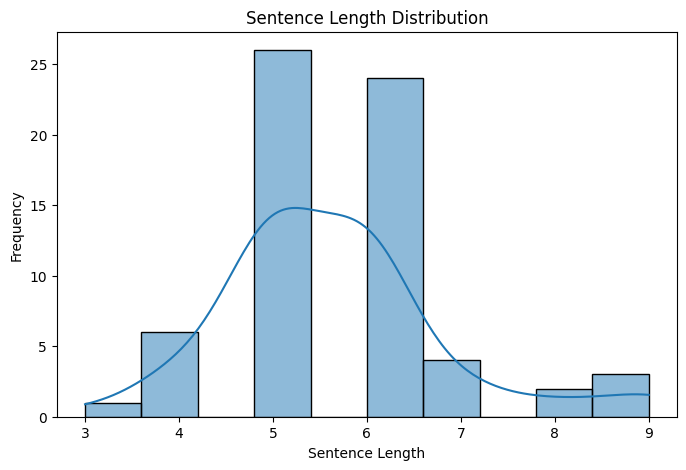

In [28]:
# Step 3: Data Analysis
print("Data Distribution Across Languages:")
print(df['language'].value_counts())

# Word Frequency Analysis
word_counts = Counter(" ".join(df['text']).split())
print("Most Common Words:", word_counts.most_common(10))

# Sentence Length Analysis
df['sentence_length'] = df['text'].apply(lambda x: len(x.split()))
print("Sentence Length Statistics:")
print(df['sentence_length'].describe())

plt.figure(figsize=(8, 5))
sns.histplot(df['sentence_length'], bins=10, kde=True)
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Sentence Length Distribution")
plt.show()

In [30]:
# Step 4: Feature Extraction
vectorizer = TfidfVectorizer(ngram_range=(1, 2), analyzer='char')
X = vectorizer.fit_transform(df['text'])
y = df['language']

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
# Step 5: Traditional ML Model (Naive Bayes)
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Model Performance:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Model Performance:
              precision    recall  f1-score   support

       Hindi       1.00      1.00      1.00         6
     Marathi       1.00      1.00      1.00         4
     Punjabi       1.00      1.00      1.00         4

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



In [35]:
# Step 6: Deep Learning Model (LSTM)
MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH = 20
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
X_seq = tokenizer.texts_to_sequences(df['text'])
X_pad = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LENGTH)

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_pad, y, test_size=0.2, random_state=42)

y_train_dl = pd.get_dummies(y_train_dl).values
y_test_dl = pd.get_dummies(y_test_dl).values

In [36]:
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_pad, y, test_size=0.2, random_state=42)

y_train_dl = pd.get_dummies(y_train_dl).values
y_test_dl = pd.get_dummies(y_test_dl).values

model = Sequential([
    Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_dl, y_train_dl, epochs=5, batch_size=4, validation_data=(X_test_dl, y_test_dl))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.3906 - loss: 1.0883 - val_accuracy: 0.2857 - val_loss: 1.0823
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5198 - loss: 1.0541 - val_accuracy: 0.7143 - val_loss: 1.0283
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8277 - loss: 0.9533 - val_accuracy: 0.9286 - val_loss: 0.9420
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9769 - loss: 0.8051 - val_accuracy: 0.9286 - val_loss: 0.7766
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.5572 - val_accuracy: 1.0000 - val_loss: 0.5143


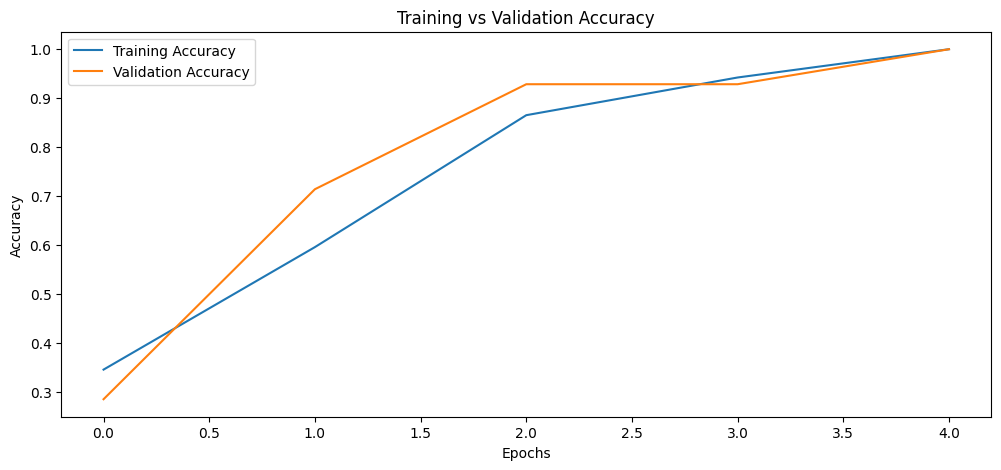

In [39]:
# Visualization of Loss and Accuracy
plt.figure(figsize=(12,5))
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


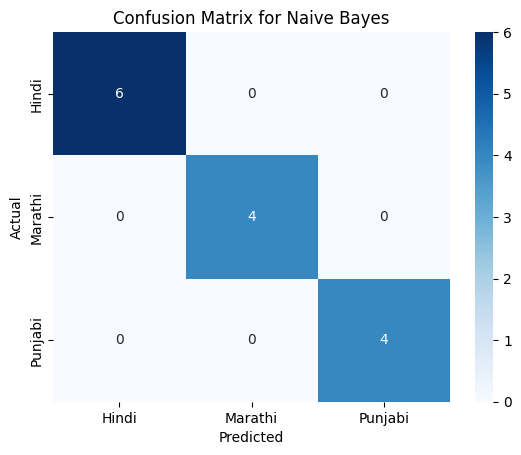

Challenges: Classifying closely related languages is difficult due to high lexical overlap.
Possible Improvements: Use larger datasets, better feature extraction (word embeddings), or fine-tuned transformer models.


In [38]:
# Step 5: Evaluation and Analysis
conf_matrix = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Naive Bayes")
plt.show()

# Step 6: Discussion & Improvements
print("Challenges: Classifying closely related languages is difficult due to high lexical overlap.")
print("Possible Improvements: Use larger datasets, better feature extraction (word embeddings), or fine-tuned transformer models.")
